In [1]:
from __future__ import print_function

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,TensorBoard,ReduceLROnPlateau

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.activations import relu
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
# from tensorflow.keras.datasets import mnist, cifar10
import tensorflow_addons as tfa

import sklearn

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from scipy.io import loadmat 
import mat73
from datetime import datetime
import ipynbname

print("Packages Loaded")

Packages Loaded


In [2]:
import wandb
from wandb.keras import WandbCallback
time_stamp = datetime.strftime( datetime.now(),'%d_%B_%y_%H%M')
wandb.init(project="my-test-project", entity="ibksolar", name=ipynbname.name()+'_'+time_stamp)
 

wandb: Currently logged in as: ibksolar (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [3]:
# Load data
# raw_data1 = loadmat('new_echo_cnn_in_out_jstarrs2021_first_try/echo_cnn_in_out_jstars1.mat')
# raw_data1 = loadmat('echo_cnn_in_out_GOOD_layers/new_echo_cnn_in_out_jstars1.mat') 'findpeaks_layers/new_echo_cnn_in_out_jstars1.mat'
load_old_data = False

if load_old_data:
    
    raw_data1 = loadmat('../../../Python_Env/final_layers_rowblock15_21/filtered_image/new_echo_cnn_in_out_jstars1.mat')
    raw_data2 = loadmat('../../../Python_Env/final_layers_rowblock15_21/filtered_image/new_echo_cnn_in_out_jstars2.mat')
    raw_data3 = loadmat('../../../Python_Env/final_layers_rowblock15_21/filtered_image/new_echo_cnn_in_out_jstars3.mat')
    # raw_data4 = loadmat('findpeaks_layers_rowblock20/new_echo_cnn_in_out_jstars4.mat')

    d1 = raw_data1['echo_cnn1']
    t1 = raw_data1['echo_target1']
    i1 = raw_data1['echo_idx1']

    d2 = raw_data2['echo_cnn2']
    t2 = raw_data2['echo_target2']
    i2 = raw_data2['echo_idx2']

    d3 = raw_data3['echo_cnn3']
    t3 = raw_data3['echo_target3']
    i3 = raw_data3['echo_idx3']

    # d4 = raw_data4['echo_cnn4']
    # t4 = raw_data4['echo_target4']
    # i4 = raw_data4['echo_idx4']

    all_data = np.concatenate( (d1,d2,d3),axis = 0 )
    all_target = np.concatenate( (t1,t2,t3),axis = 0 )
    all_idx = np.concatenate( (i1,i2,i3),axis = 0 )

    # Set all nan in the data to zero
    nan_idx = np.isnan(all_data).any(axis =-1)
    all_target[nan_idx] = 0
    all_data[ np.isnan(all_data) ]= 0

In [6]:
load_new_data = True

if load_new_data:
    # base_path = '..\\..\\all_block_data\Dec_Train_block_len_21_011121_2331'
    #base_path = '../all_block_data/Old_data/Dec_Train_block_len_21_231121_1531'
    base_path = '../all_block_data\PulsedTrainTest\Dec_Train_block_len_21_220122_1449_FindPeaks'

    # Confirm path is right...
    print(f'{os.path.isdir(base_path)}')

True


In [11]:
if load_new_data:
    raw_data1 = mat73.loadmat(base_path + '/echo_cnn_in_out_jstars.mat')
    all_data = raw_data1['echo_cnn_input']
    all_target = raw_data1['echo_cnn_target']
    all_coords = raw_data1['coords']
    echo_idx = raw_data1['orig_echo_idx']

    # Set all nan in the data to zero
    nan_idx = np.isnan(all_data).any(axis =-1)
    all_target[nan_idx] = 0
    all_data[ np.isnan(all_data) ]= 0



In [12]:
# Standardize all_data
standardize = False
if standardize:
    all_data  = ( all_data - all_data.mean() ) / all_data.std()

scale_data = False
if scale_data:
    all_data = 255*all_data

In [13]:
# Truncate data because data after truncate point is not good for training

truncate_data = False
if truncate_data:    
    echo_idx = np.asarray(echo_idx)
    stop_val = 400

    stop_list, = np.where(echo_idx == stop_val)
    stop_idx = stop_list[-1]

    all_data = all_data[:stop_idx]
    all_target = all_target[:stop_idx]

    print(f'Data shape {all_data.shape}')
    print(f'Target shape {all_target.shape}')


In [14]:
row_length = 21 # CHANGE HERE <==
col_length = 15

# Check that the dimension of data is correct
if all_data.shape[1] == row_length*col_length:
    print('Dimensions match')
else:
    print(f' Row block length:{row_length} and col length:{col_length} does not match Data dimension:{all_data.shape[1]}') 
        

Dimensions match


In [ ]:
# Positional Encoding
time_seq = 9 #col_length #5
# all_coords = raw_data1['coords']
all_coord_exp = np.zeros((all_coords.shape[0],time_seq,row_length))

for idx in range(len(all_coords)):
    a,b,c,_ = np.asarray(all_coords[idx],dtype="int")
    if (a%2) == 0: # If row index is even - this isn't implemented well because it requires iterating through individual rows
        all_coord_exp[idx] = np.sin( np.outer( np.arange(c,c+time_seq), pow(10000, (2*np.arange(a,b)/row_length)) ) )
    else:
        all_coord_exp[idx] = np.cos( np.outer( np.arange(c,c+time_seq), pow(10000, (2*np.arange(a,b)/row_length)) ) )

if 0: #truncate_data:
    difficult_coords = all_coord_exp[stop_idx+1:]         
    all_coord_exp = all_coord_exp[:stop_idx]        
   
    
all_coord_exp.shape    

In [15]:
max_class = row_length 
neigh = 4 # The number of neighbors used for each RowBlock column

# Highest class is mapped to row_length+1
all_target[all_target == max_class+1 ] = 0


shuffle = 1
if shuffle:
    random.Random(13).shuffle(all_data)
    random.Random(13).shuffle(all_target)
    #random.Random(13).shuffle(all_coord_exp)
    # random.Random(1337).shuffle(all_idx)

## Prep data
train_size = int(np.floor(0.8*len(all_target)));
test_size = int(np.round( 0.15* all_data.shape[0] ))
val_size = all_data.shape[0] -train_size - test_size

mid_pt = 8


x_train = all_data[0:train_size,:]
x_train = np.reshape( x_train, (x_train.shape[0],max_class,-1),order ='F' )
x_train = x_train[:,:,mid_pt-neigh:mid_pt+neigh+1]
# x_train = np.reshape(x_train,(x_train.shape[0],-1))
x_train = np.transpose(x_train,(0,2,1))
#coords_train = all_coord_exp[0:train_size,:]


x_test = all_data[train_size:train_size+test_size,:]
x_test = np.reshape( x_test,(x_test.shape[0],max_class,-1),order ='F' )
x_test = x_test[:,:,mid_pt-neigh:mid_pt+neigh+1]
# x_test = np.reshape(x_test,(x_test.shape[0],-1))
x_test = np.transpose(x_test,(0,2,1))
#coords_test = all_coord_exp[train_size:train_size+test_size,:]


x_val = all_data[-val_size:,:]
x_val = np.reshape( x_val,(x_val.shape[0],max_class,-1),order ='F' )
x_val = x_val[:,:,mid_pt-neigh:mid_pt+neigh+1]
# x_val = np.reshape(x_val,(x_val.shape[0],-1))
x_val = np.transpose(x_val,(0,2,1))
#coords_val = all_coord_exp[-val_size:,:]


y_train = all_target[:train_size]
y_test  = all_target[train_size:train_size+test_size]
y_val = all_target[-val_size:]

var_input_shape = x_train.shape[1:] # 240 columns
num_classes = max_class+1 # layers


# Convert labels to categorical orthonormal vectors
y_train_1hot = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_1hot  = tf.keras.utils.to_categorical(y_test, num_classes)

print(f'Shape of X_train:{x_train.shape}  X_test:{x_test.shape}')
print(f'Shape of y_train:{y_train.shape}  y_test:{y_test.shape}')

Shape of X_train:(993792, 9, 21)  X_test:(186336, 9, 21)
Shape of y_train:(993792,)  y_test:(186336,)


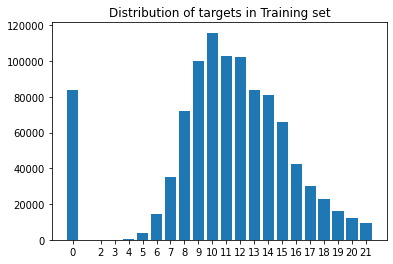

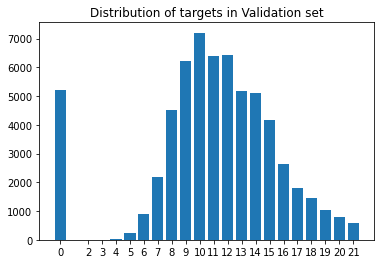

In [16]:
# Show distribution of targets in training and validation set

labels, counts = np.unique(y_train, return_counts=True)
_ = plt.bar(labels, counts, align='center')
_ = plt.gca().set_xticks(labels)
_ = plt.title('Distribution of targets in Training set')
_ = plt.show()


labels, counts = np.unique(y_val, return_counts=True)
_ = plt.bar(labels, counts, align='center')
_ = plt.gca().set_xticks(labels)
_ = plt.title('Distribution of targets in Validation set')
_ = plt.show()

In [ ]:

x_train_new = x_train + coords_train
x_test_new = x_test + coords_test
x_val_new = x_val + coords_val

In [17]:
# Populate the param 

# import sys,importlib
#importlib.reload(sys.modules['model_hyper_param_log'])

base_path =  r'../../../Python_Env/final_layers_rowblock15_21/filtered_image/new_echo_cnn_in_out_jstars3.mat'
log ={}
log['Notebook_name'] = ipynbname.name()
log['Uniqueness_of_each_run'] = 'Another run of Pulsed Train of findpeaks data using improved base -good LSTM1 model '
log['base_dir'] = base_path
log['Train_shape'] = x_train.shape
log['Output_shape'] = ''
log['num_epochs'] = ''
log['batch_size'] = ''
log['activation_function'] = ''
log['optimizer'] = ''
log['learning_rate'] = ''
log['loss_finction'] = ''
log['accuracy'] = []
log['loss'] = []
log['stop_time'] = ''
log['Model_config'] = ''
log['Performance_on_test_set'] = ''
log['output_path'] = ''  # output: where the trained model is saved
log['shuffle'] = shuffle
log['run_completion_comment'] = '' # Comment on training and probably evaluation too
log['extras'] = [{'standardize':standardize}]


from model_hyper_param_log import create_log_entry, update_log_entry
if "log_idx" in globals():
    log["S_N"] = log_idx
log_idx = create_log_entry('../testing_sheet2.xlsx', log)

ImportError: Missing optional dependency 'openpyxl'.  Use pip or conda to install openpyxl.

In [ ]:
# Visualize some of the input

_ = plt.plot(x_train[200].flatten())
_ = plt.title(y_train[200])

In [ ]:
# Custom ResNet + LSTM model

num_epochs = 300
batch_size = 512
learning_rate = 1e-3

input_shape = (x_train.shape[1:]) + (1,) #input_shape = (21,5,) #x_train.shape[2]

def ResNetBlock(x,dropout):
    x =   layers.Conv2D(filters=64, kernel_size=5, padding="same")(x) #input_layer
    conv1 = layers.Conv2D(filters=64, kernel_size=5, padding="same")(x) # input_layer, Conv1D
    conv1 = layers.Dropout(dropout)(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.ReLU()(conv1)

    conv2 = layers.Conv2D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = layers.Dropout(dropout)(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.ReLU()(conv2)

    conv3 = layers.Conv2D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = layers.Dropout(dropout)(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.ReLU()(conv3)
    
    conv3 = layers.Conv2D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = layers.Dropout(dropout)(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.ReLU()(conv3)
    
    conv3 = layers.add([x,conv3])
    x = layers.ReLU()(conv3) # Overwrite x
    
    return x


def build_model(
    input_shape,
    head_size,  
    mlp_units,
    dropout,
    mlp_dropout,
):
    inputs = tf.keras.Input(shape=input_shape)  
    
    x = layers.Conv2D(filters=32, kernel_size=3, padding="same")(inputs)
    for _ in range(5):
        x = ResNetBlock(x,dropout)        
    x = tf.reduce_sum(x,axis=-1)
    
    x = layers.LSTM(head_size,recurrent_dropout=0.1, return_sequences=True)(x) #input_shape=(x.shape[1:]),
    x = layers.LSTM(head_size,recurrent_dropout=0.1, return_sequences=True)(x)
    x = layers.LSTM(head_size,recurrent_dropout=0.1, return_sequences=True)(x)
    x = layers.LSTM(64,recurrent_dropout= 0.3)(x)

       
    #for dim in mlp_units:  x = layers.Dense(dim, activation="relu")(x)
    x = layers.Dense(mlp_units, activation="relu")(x)
    x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return tf.keras.Model(inputs, outputs,name ="RowBlockLSTM"+time_stamp)

head_size = 512 # 128, 256,64
mlp_units=512  # 128
mlp_dropout=0.01     #0.4
dropout=0.015          #0.25

model = build_model(input_shape,head_size = head_size,mlp_units=mlp_units, mlp_dropout= mlp_dropout, dropout=dropout)
model.summary()

## Logging tools
wandb.config = {
  "learning_rate": "learning_rate",
  "epochs": num_epochs, 
  "batch_size": batch_size,
  #"nodes": nodes,
  "row_length":row_length,
  "base_path":base_path,
  "head_size":head_size, 
  # "ff_dim":ff_dim, "num_transformer_blocks":num_transformer_blocks,"num_heads":num_heads,
  "mlp_units":mlp_units, "mlp_dropout":mlp_dropout,
  "dropout":dropout
}

# Update Wandb fieds with more params
wandb.config.update(log)

# Update log['extras']
log['extras'][0].update(wandb.config)
#### ===== End of logging ========



# Poly Rate scheduler
starter_learning_rate = 0.1
end_learning_rate = 0.0001
decay_steps = 10000
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=0.25)


# Callbacks
callbacks = [
    ModelCheckpoint(f"{ipynbname.name()}//RowBlockLSTM_checkpoint_{time_stamp}.h5", save_best_only=True, monitor="val_loss"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, min_lr=0.0001, verbose = 1),
    #EarlyStopping(monitor="val_loss", patience=25, verbose=1), 
    WandbCallback()
]

opt1 = tf.keras.optimizers.RMSprop(learning_rate=1e-3,rho=0.9,momentum=0.9, epsilon=1e-07,centered=True,name="RMSprop")
opt2 = tf.keras.optimizers.Adam(learning_rate=learning_rate,amsgrad=True)
opt3 = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.99, nesterov=True, name="SGD")
poly_rate = tf.keras.optimizers.SGD(learning_rate = learning_rate_fn)

top_K = 3
start_time = datetime.strftime( datetime.now(),'%d_%B_%y_%H%M')

print(f'Training start time:{start_time}')

# model.compile( optimizer = opt, loss= 'categorical_crossentropy', metrics=['accuracy',tf.keras.metrics.TopKCategoricalAccuracy(top_K, name="top-3-accuracy")])  #label_smoothing=0.05, tf.keras.losses.KLDivergence()
#model.compile( optimizer=opt1,loss="sparse_categorical_crossentropy" , metrics=["sparse_categorical_accuracy"],) #"sparse_categorical_crossentropy" , sparse_categorical_accuracy", tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.3)

model.compile( optimizer=opt3,loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2) , 
              metrics=["accuracy", tf.keras.metrics.TopKCategoricalAccuracy(top_K, name="top-3-accuracy")], ) #"sparse_categorical_crossentropy" , sparse_categorical_accuracy", tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.3)


history = model.fit(x_train, y_train_1hot,
          epochs= num_epochs, 
          batch_size= batch_size, 
          validation_split = 0.3,
          # validation_data=(x_test, y_test_1hot),
         callbacks=callbacks) #mcp_save, callbacks=[reduce_lr_loss]

model = tf.keras.models.load_model("{ipynbname.name()}//RowBlockLSTM_checkpoint_{time_stamp}.h5")

# Update manual log file
params_to_be_updated = update_log_entry('../testing_sheet2.xlsx', log_idx, model, history)

# Previous Acc was ~35%

Model: "RowBlockLSTM26_January_22_1620"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 9, 21, 1)]   0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 9, 21, 32)    320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 9, 21, 64)    51264       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 9, 21, 64)    102464      conv2d_1[0][0]                   
_____________________________________________________________________

C:\Users\i368o351\Anaconda3\envs\ibk_sept21_tf2.5\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/300
1359/1359 [==============================] - 445s 327ms/step - loss: 2.7751 - accuracy: 0.1842 - top-3-accuracy: 0.4124 - val_loss: 2.5496 - val_accuracy: 0.3816 - val_top-3-accuracy: 0.6400
Epoch 3/300
1359/1359 [==============================] - 444s 327ms/step - loss: 2.7374 - accuracy: 0.2266 - top-3-accuracy: 0.4410 - val_loss: 2.5542 - val_accuracy: 0.3542 - val_top-3-accuracy: 0.6142
Epoch 4/300
1359/1359 [==============================] - 447s 329ms/step - loss: 2.7285 - accuracy: 0.2363 - top-3-accuracy: 0.4452 - val_loss: 2.5447 - val_accuracy: 0.3746 - val_top-3-accuracy: 0.6062
Epoch 5/300
1359/1359 [==============================] - 444s 327ms/step - loss: 2.7242 - accuracy: 0.2402 - top-3-accuracy: 0.4476 - val_loss: 2.4738 - val_accuracy: 0.4345 - val_top-3-accuracy: 0.6611
Epoch 6/300
1359/1359 [==============================] - 446s 328ms/step - loss: 2.7211 - accuracy: 0.2431 - top-3-accuracy: 0.4500 - val_loss: 2.4754 - val_accuracy: 0.4297 - val_top-3-ac

In [ ]:
log['Uniqueness_of_each_run'] = 'Using Old data from its source'
run_completion_comment = f'First time training LSTM on FilteredFiltered Old data. BEST accuracy(92%) so far but yet to try on val data'
if "log_idx" in globals():
    log["S_N"] = log_idx
    log['extras'][0]['run_completion_comment'] = run_completion_comment #'Accuracy_per_epoch'
    log['Accuracy_per_epoch'] = '44%'
    log_idx = create_log_entry('../testing_sheet2.xlsx', log)

In [ ]:
def PlotCurves(model_history):
    plt.plot(model_history.history['accuracy'],label = 'train')
    plt.grid(color = 'r', linestyle = '--', linewidth = .1)    
    #plt.figure()
    plt.plot(model_history.history['val_accuracy'],label = 'validation')
   
    plt.ylabel('Accuracy');
    plt.xlabel('Epochs');
    
    plt.title('Training vs Validation accuracy');
    plt.legend()
    
    plt.figure()
    
    plt.plot(model_history.history['loss'],label = 'train')
    plt.grid(color = 'r', linestyle = '--', linewidth = .1)    
    plt.plot(model_history.history['val_loss'],label = 'validation')
   
    plt.ylabel('Loss');
    plt.xlabel('Epochs');
    
    plt.title('Training vs Validation Losses');
    plt.legend()
    return None

PlotCurves(history)

In [ ]:
# Convert labels to categorical orthonormal vectors
y_val_1hot = tf.keras.utils.to_categorical(y_val, num_classes)

_, accuracy,top3_acc = model.evaluate(x_val, y_val_1hot)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top3_acc * 100, 2)}%")

_,new_col_length,new_row_length = x_train.shape 
model.save(f'{base_path}//{ipynbname.name()}//{time_stamp}_Acc_{accuracy:.3f}_Top3Acc{top3_acc:.3f}_{new_row_length}x{new_col_length}.h5') # Last percentage is 46.85, New:52.4

In [28]:
# Test model manually on all val data

y_pred = [ np.argmax(model.predict(np.expand_dims(x_val[idx],axis=0))) for idx in range(len(x_val)) ]

combined_result = zip(y_val,y_pred)

val_exact_accuracy = 100 * sum([1 if y_pred[idx]==y_val[idx]   else 0 for idx in range(len(y_pred)) ]) / len(y_pred)
val_margin5_accuracy = 100 * sum([1 if abs(y_pred[idx]-y_val[idx]) < 5 else 0 for idx in range(len(y_pred)) ]) / len(y_pred)

print(f' Exact accuracy is {val_exact_accuracy: .5f} %')
print(f' Top 5% accuracy is {val_margin5_accuracy: .5f} %')



 Exact accuracy is  78.09492 %
 Top 5% accuracy is  88.43487 %


In [84]:
# Confusion Matrix and ROC/AUC

model_predictions = np.asarray(y_pred)
ground_truth = y_val.squeeze()

# Prediction per Ground-truth class
class_predictions = [ model_predictions[ground_truth==idx]  for idx in range(num_classes) ]

# Confusion matrix
confusion_mtx = np.zeros((num_classes,num_classes) )

for pred,actual in zip(y_pred,y_val): # Rows=Prediction, Columns = Actual
    confusion_mtx[pred,actual] +=1

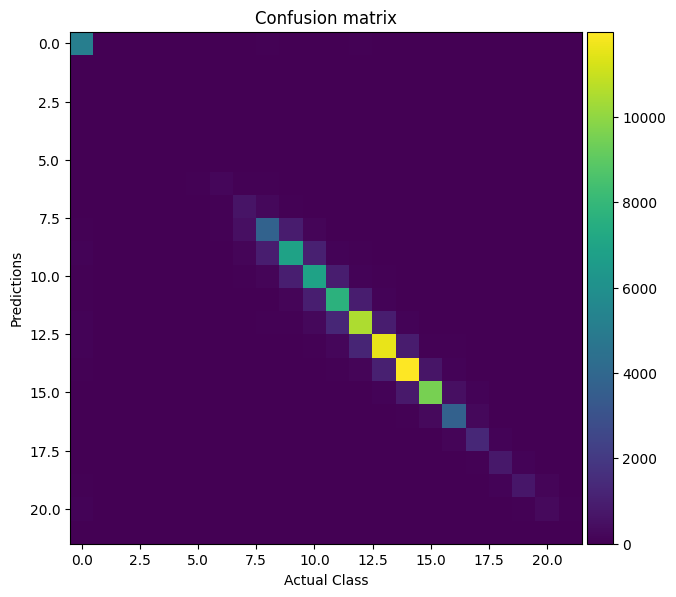

In [136]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(7,15),dpi = 100);
shw=ax.imshow(confusion_mtx)
#bar= plt.colorbar(shw)

_=plt.ylabel('Predictions')
_=plt.xlabel('Actual Class')
_=plt.title('Confusion matrix')

# ax.set_xticklabels(list(range(num_classes)))
# ax.set_yticklabels(list(range(num_classes)))

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
#bar.set_label('ColorBar')
_ = plt.colorbar(shw, cax=cax)

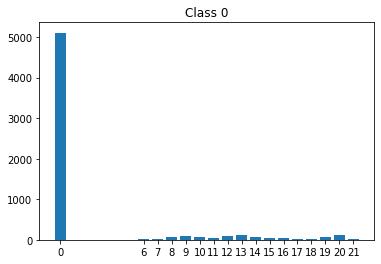

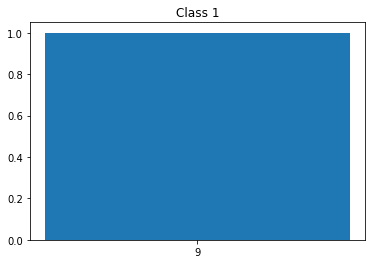

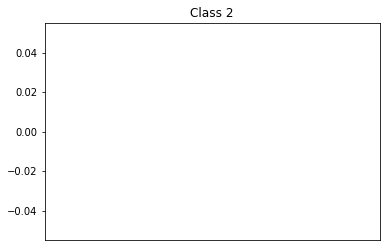

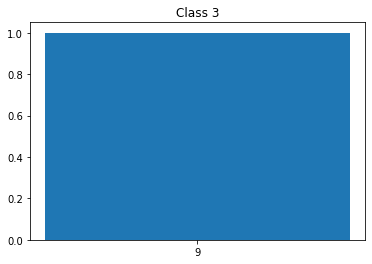

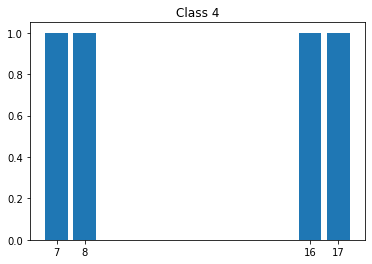

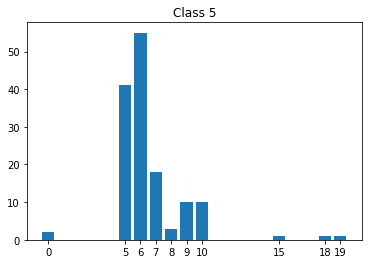

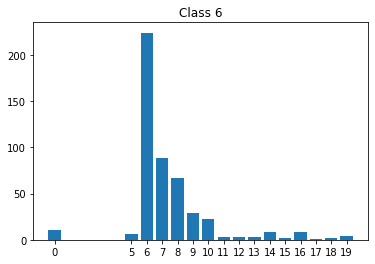

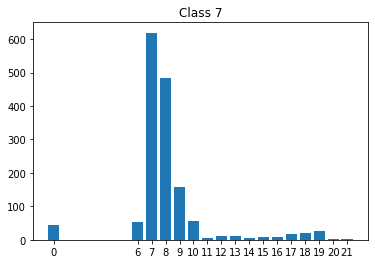

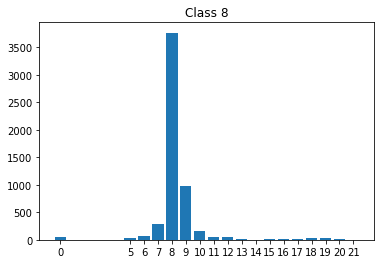

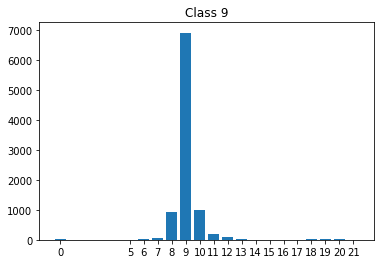

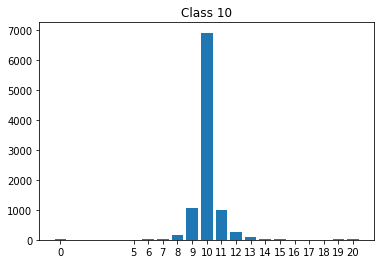

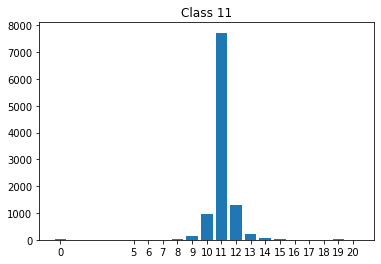

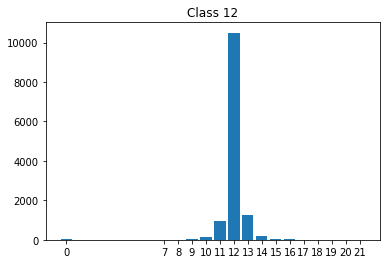

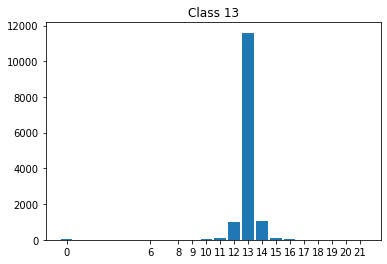

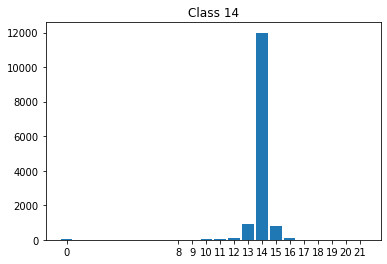

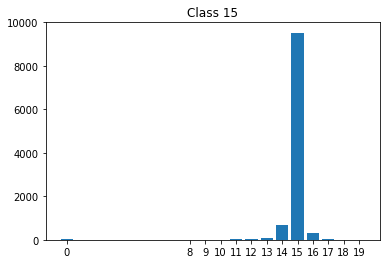

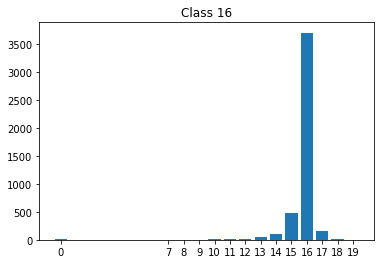

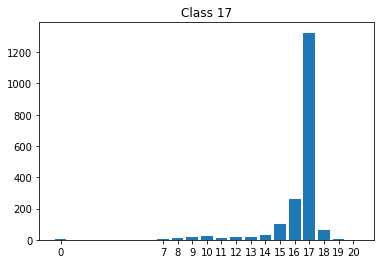

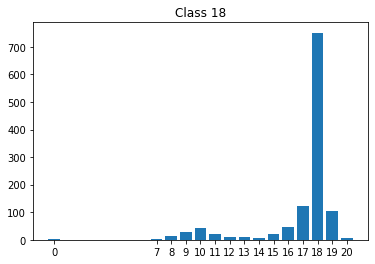

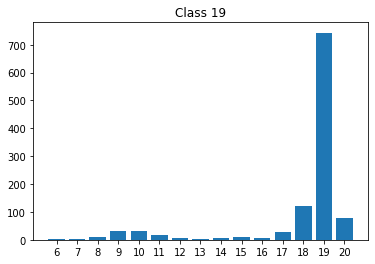

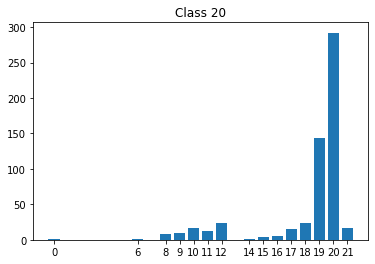

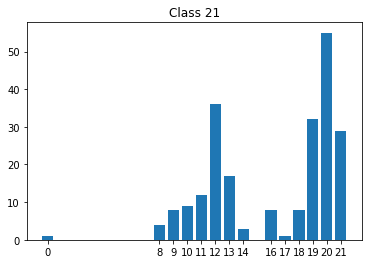

In [96]:
# Histogram of each class prediction
for idx,each_class in enumerate(class_predictions):
    _ = plt.figure()
    _ = plt.title('Class %s'%idx)
    labels, counts = np.unique(each_class, return_counts=True)
    _ = plt.bar(labels, counts, align='center')
    _ = plt.gca().set_xticks(labels)
    _ = plt.show()

In [147]:
from sklearn.metrics import classification_report

print( classification_report( y_val,y_pred, labels=list(range(num_classes)), zero_division=1 ))

              precision    recall  f1-score   support

           0       0.94      0.85      0.89      6026
           1       1.00      0.00      0.00         1
           2       1.00      1.00      1.00         0
           3       1.00      0.00      0.00         1
           4       1.00      0.00      0.00         4
           5       0.49      0.29      0.36       142
           6       0.50      0.46      0.48       482
           7       0.56      0.40      0.47      1536
           8       0.68      0.68      0.68      5561
           9       0.73      0.74      0.73      9359
          10       0.73      0.72      0.72      9623
          11       0.76      0.74      0.75     10508
          12       0.77      0.80      0.79     13195
          13       0.80      0.83      0.82     14004
          14       0.85      0.85      0.85     14029
          15       0.85      0.89      0.87     10712
          16       0.81      0.81      0.81      4559
          17       0.74    

In [25]:
# Check some predictions

import random
check_start = random.randint(0,len(x_val))

print(f'Check start {check_start}')
[(int(y_val[idx]), np.argmax(model.predict(np.expand_dims(x_val[idx],axis=0))) ) for idx in range(check_start,check_start+20) ]



Check start 5539


[(10, 9),
 (15, 15),
 (12, 13),
 (12, 12),
 (13, 13),
 (17, 16),
 (11, 9),
 (12, 12),
 (17, 17),
 (14, 14),
 (10, 9),
 (14, 12),
 (18, 18),
 (9, 9),
 (11, 11),
 (16, 16),
 (9, 9),
 (5, 6),
 (0, 0),
 (0, 0)]

In [ ]:
# Train further (last training 12/8/2021 was for 30 epochs - 150 epochs(w/o reshape order) previously overfitted
# Also, the train set was not reshuffled, but train further uses shuffled train data (Stopped the train further after 30 epocks- acc 14% poor. Retraining from scratch )

start_time = datetime.strftime( datetime.now(),'%d_%B_%y_%H%M')

print(f'Training start time:{start_time}')
#batch_size = 64
history2 = model.fit(x_train, y_train_1hot,
          epochs= 250, 
          batch_size= batch_size, 
          validation_data=(x_test, y_test_1hot),callbacks=callbacks) #mcp_save, callbacks=[reduce_lr_loss]callbacks=callbacks

In [ ]:
PlotCurves(history2)

In [ ]:
_, accuracy,top_3_accuracy = model.evaluate(x_val, y_val_1hot)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_3_accuracy * 100, 2)}%")

_,new_col_length,new_row_length = x_train.shape 
model.save(f'{base_path}//{ipynbname.name()}//{time_stamp}_Acc_{accuracy:.3f}_top3{top_3_accuracy:.3f}_{new_row_length}x{new_col_length}.h5')

In [54]:
# Try prediction on difficult data

x_difficult = raw_data1['echo_cnn_input'][stop_idx+1:]
y_difficult = raw_data1['echo_cnn_target'][stop_idx+1:]

x_difficult = np.reshape( x_difficult, (x_difficult.shape[0],max_class,-1) )
x_difficult = x_difficult[:,:,mid_pt-neigh:mid_pt+neigh+1]
# x_train = np.reshape(x_train,(x_train.shape[0],-1))
x_difficult = np.transpose(x_difficult,(0,2,1))

# y_difficult[y_difficult == num_classes] = 0
# y_difficult = tf.keras.utils.to_categorical(y_difficult, num_classes)


In [55]:
(x_difficult.shape,y_difficult.shape)

((1724672, 9, 21), (1724672,))

In [61]:
# Check some predictions

difficult_start = random.randint(0,len(x_val)) #3500 #

print(f'Check start {difficult_start}')
[(int(y_difficult[idx]), np.argmax(model.predict(np.expand_dims(x_difficult[idx],axis=0))) ) for idx in range(difficult_start,difficult_start+50) ]



Check start 32030


[(14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (19, 9),
 (19, 9),
 (19, 9),
 (19, 9),
 (19, 9),
 (19, 9),
 (19, 9),
 (19, 9),
 (19, 9),
 (19, 9),
 (19, 9),
 (19, 9),
 (19, 9),
 (19, 9),
 (19, 9),
 (19, 9)]

In [ ]:
# Attempt loading past model (after crash) and start training again
load_model = 0
if load_model:
    model2 = tf.keras.models.load_model(r'Y:\ibikunle\Python_Project\Fall_2021\all_block_data\Old_data\Dec_Train_block_len_21_131121_2213\NewAttention_RowBlockLSTM1\22_November_21_0929_Acc_0.669_Top3Acc0.8506_21x9.h5'
                                    ,)

In [ ]:
# Train further
batch_size = 64
history2 = model.fit(x_train, y_train_1hot,
          epochs= 30, 
          batch_size= batch_size, 
          validation_data=(x_test, y_test_1hot),callbacks=callbacks) #mcp_save, callbacks=[reduce_lr_loss]callbacks=callbacks

In [ ]:
# Train further still( 30th Nov.,2021 X_train is returned back to default [i.e No shuffle] )
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.001)
batch_size = 64
history2 = model.fit(x_train, y_train_1hot,
          epochs= 2, 
          batch_size= batch_size, 
          validation_data=(x_test, y_test_1hot),callbacks=callbacks) #mcp_save, callbacks=[reduce_lr_loss]callbacks=callbacks

In [ ]:
# Convert labels to categorical orthonormal vectors
y_val_1hot = tf.keras.utils.to_categorical(y_val, num_classes)

_, accuracy,top3_acc = model.evaluate(x_val, y_val_1hot)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
# print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

_,new_col_length,new_row_length = x_train.shape 
model.save(f'{base_path}//{ipynbname.name()}//{time_stamp}_Acc_{accuracy:.3f}_Top3Acc{top3_acc:.3f}_{new_row_length}x{new_col_length}.h5')

In [ ]:
# Test model on val data

y_diff_pred = [ np.argmax(model.predict(np.expand_dims(x_difficult[idx],axis=0))) for idx in range(3000,3050) ] #len(x_difficult)

difficult_exact_accuracy = 100 * sum([1 if y_diff_pred[idx]==y_difficult[idx]   else 0 for idx in range(len(y_diff_pred)) ]) / len(y_diff_pred)
difficult_margin5_accuracy = 100 * sum([1 if abs(y_diff_pred[idx]-y_difficult[idx]) < 3 else 0 for idx in range(len(y_diff_pred)) ]) / len(y_diff_pred)

print(f' Exact accuracy is {difficult_exact_accuracy: .5f} %')
print(f' Top 5% accuracy is {difficult_margin5_accuracy: .5f} %')



In [ ]:
len(y_diff_pred)